# Gerenciamento de Dependências

In [1]:
# Upgrade do pip
!pip install --upgrade pip

# Instalação dos pacotes
!pip install gdown # Serve pra baixar arquivos do google drive
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install missingno
!pip install matplotlib
!pip install scikit-learn

In [2]:
# Import dos Pacotes
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from scipy.stats import chi2_contingency

# Download do Dataset

In [3]:
!gdown 1ISRC99c1SyDwpsWh5E8OjSMtxpd6ux22

Downloading...
From: https://drive.google.com/uc?id=1ISRC99c1SyDwpsWh5E8OjSMtxpd6ux22
To: /home/julio/Documentos/faculdade_ia_machine-learning-and-n8n/sods.csv
100%|████████████████████████████████████████| 849k/849k [00:00<00:00, 1.68MB/s]


# Visualização dos Dados

## Funções Auxiliares

In [4]:
def show_distribution_hist(dataset):
    dataset
    for key in dataset.keys():
        print(f"Key: {key}")
        # sns.kdeplot(dataset[key], fill=True)

def show_distribution(dataset):
    ...

## Plots
***
Idade: label com dados númericos, não categóricos. Devo analisar a distribuição, os valores assumidos, o número de valores faltando e, a existência de outliers. Suponho, que algo entre 1 ano à 122 anos, que foi a idade de uma senhorinha que viveu que só, vou usar 125 pra arredondar.

Genêro: label com dados textuais e, categóricos. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Suponho, que seja masculino, feminino e outros. Vou precisar fazer o encode, posteriormente.

Etnia:  label com dados textuais e, categóricos. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Suponho, que seja parda, branca e negra. Vou precisar fazer o encode, posteriormente.

PCD (Pessoa com Deficiência): label com dados binários, sim ou não. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Vou precisar fazer o encode, posteriormente.

Vive no Brasil: label com dados binários, True ou False. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Vou precisar fazer o encode, posteriormente.

Estado de moradia: label com dados textuais e, categóricos. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Devo verificar também se a label assume valores de estados fora do Brasil. Vou precisar fazer o encode, posteriormente.

Nível de ensino:

Formação:

Tempo de experiência:

Linguagens preferidas:

Banco de dados:

Cloud preferida:

Cargo:
***

In [43]:
# Carregar o dataset e ver algumas informações básicas
dataset = pd.read_csv("sods.csv") 
dataset

,idade,genero,etnia,pcd,vive_no_brasil,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,39.0,Masculino,Parda,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,R,"PostgreSQL, Oracle, MySQL, SQL SERVER",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados
1,32.0,Masculino,Parda,Não,True,Pará (PA),Graduação/Bacharelado,Outras Engenharias,de 3 a 4 anos,NaN,NaN,NaN,NaN
2,53.0,Masculino,Branca,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, MySQL, Oracle, DB2",Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
3,27.0,Masculino,Branca,Não,True,Minas Gerais (MG),Doutorado ou Phd,Estatística/ Matemática / Matemática Computaci...,de 4 a 6 anos,Python,Google BigQuery,Não sei opinar,Cientista de Dados/Data Scientist
4,46.0,Feminino,Branca,Não,True,Pará (PA),Pós-graduação,Computação / Engenharia de Software / Sistemas...,Não tenho experiência na área de dados,Python,Microsoft Access,Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,26.0,Masculino,Branca,Não,True,São Paulo (SP),Graduação/Bacharelado,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, Oracle, MariaDB, HBase, MySQL",Não sei opinar,Analista de Dados/Data Analyst
4267,30.0,Feminino,Branca,Não,True,Minas Gerais (MG),Mestrado,Outras Engenharias,de 1 a 2 anos,Python,"SQL SERVER, SAP HANA",Azure (Microsoft),Engenheiro de Dados/Arquiteto de Dados/Data En...
4268,29.0,Masculino,Branca,Não,True,São Paulo (SP),Mestrado,Outras Engenharias,de 4 a 6 anos,NaN,NaN,NaN,NaN
4269,NaN,Masculino,Branca,Não,True,São Paulo (SP),Não tenho graduação formal,NaN,Menos de 1 ano,Python,"Microsoft Access, Oracle",Azure (Microsoft),Outra Opção


Removendo todas as linhas em que valores do target estiverem faltando.

In [44]:
target = "cargo"
dataset = dataset.dropna(subset=[target])
dataset

,idade,genero,etnia,pcd,vive_no_brasil,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,39.0,Masculino,Parda,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,R,"PostgreSQL, Oracle, MySQL, SQL SERVER",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados
2,53.0,Masculino,Branca,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, MySQL, Oracle, DB2",Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
3,27.0,Masculino,Branca,Não,True,Minas Gerais (MG),Doutorado ou Phd,Estatística/ Matemática / Matemática Computaci...,de 4 a 6 anos,Python,Google BigQuery,Não sei opinar,Cientista de Dados/Data Scientist
4,46.0,Feminino,Branca,Não,True,Pará (PA),Pós-graduação,Computação / Engenharia de Software / Sistemas...,Não tenho experiência na área de dados,Python,Microsoft Access,Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
5,32.0,Feminino,Parda,Não,True,Ceará (CE),Pós-graduação,Ciências Biológicas/ Farmácia/ Medicina/ Área ...,Não tenho experiência na área de dados,Python,Google BigQuery,Google Cloud (GCP),Professor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4265,28.0,Masculino,Branca,Não,True,Paraná (PR),Graduação/Bacharelado,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Julia,SQLite,Azure (Microsoft),Analista de Marketing
4266,26.0,Masculino,Branca,Não,True,São Paulo (SP),Graduação/Bacharelado,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, Oracle, MariaDB, HBase, MySQL",Não sei opinar,Analista de Dados/Data Analyst
4267,30.0,Feminino,Branca,Não,True,Minas Gerais (MG),Mestrado,Outras Engenharias,de 1 a 2 anos,Python,"SQL SERVER, SAP HANA",Azure (Microsoft),Engenheiro de Dados/Arquiteto de Dados/Data En...
4269,NaN,Masculino,Branca,Não,True,São Paulo (SP),Não tenho graduação formal,NaN,Menos de 1 ano,Python,"Microsoft Access, Oracle",Azure (Microsoft),Outra Opção


Número de valores faltando.
idade: 38 -> 0.89%
genero: 6 -> 0.14%
etnia: 0 -> 0.00%
pcd: 0 -> 0.00%
vive_no_brasil: 0 -> 0.00%
estado_moradia: 72 -> 1.69%
nivel_ensino: 0 -> 0.00%
formacao: 74 -> 1.73%
tempo_experiencia_dados: 0 -> 0.00%
linguagens_preferidas: 2 -> 0.05%
bancos_de_dados: 3 -> 0.07%
cloud_preferida: 0 -> 0.00%
cargo: 0 -> 0.00%


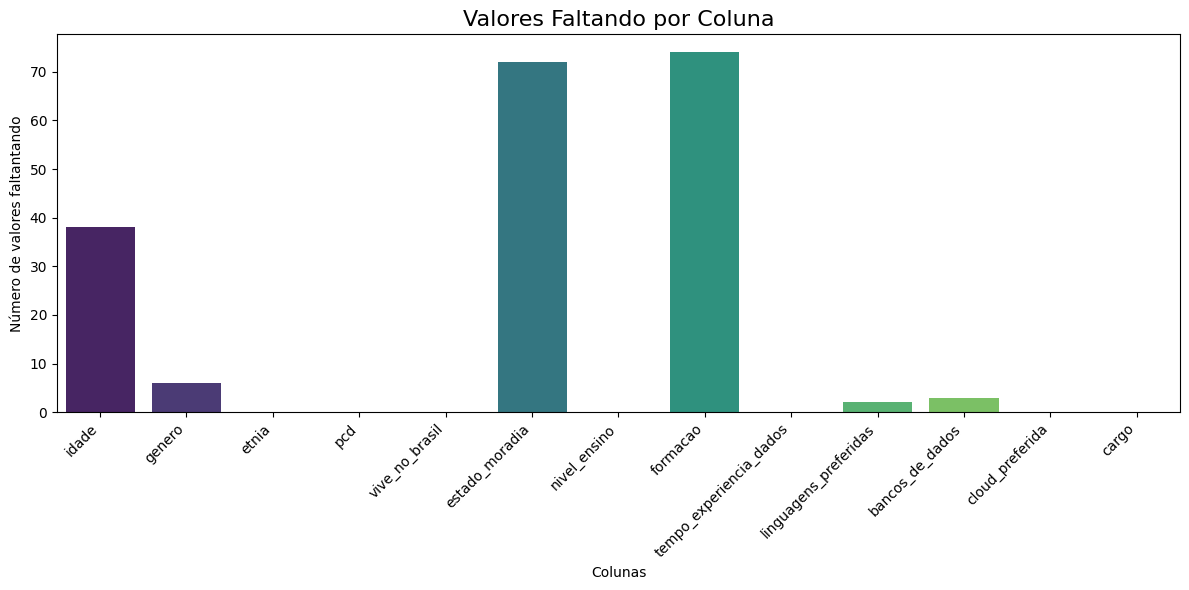

In [45]:
# Verificar o  número de valores ausentes nas tabelas.

missing_counts = dataset.isnull().sum().reset_index()
missing_counts.columns = ["coluna", "valores_faltantes"]

print("Número de valores faltando.")
for col, val in dataset.isnull().sum().items():
    print(f"{col}: {val} -> {val/4271*100:.2f}%")

plt.figure(figsize=(12,6))
sns.barplot(data=missing_counts, 
            x="coluna", 
            y="valores_faltantes",
            hue="coluna",
            palette="viridis",
            legend=False,
            dodge=False)

plt.xticks(rotation=45, ha='right')
plt.title("Valores Faltando por Coluna", fontsize=16)
plt.xlabel("Colunas")
plt.ylabel("Número de valores faltantando")
plt.tight_layout()
plt.show()

# Pode ser uma boa printar também o número geral de linhas que possui pelo menos um valor faltando.

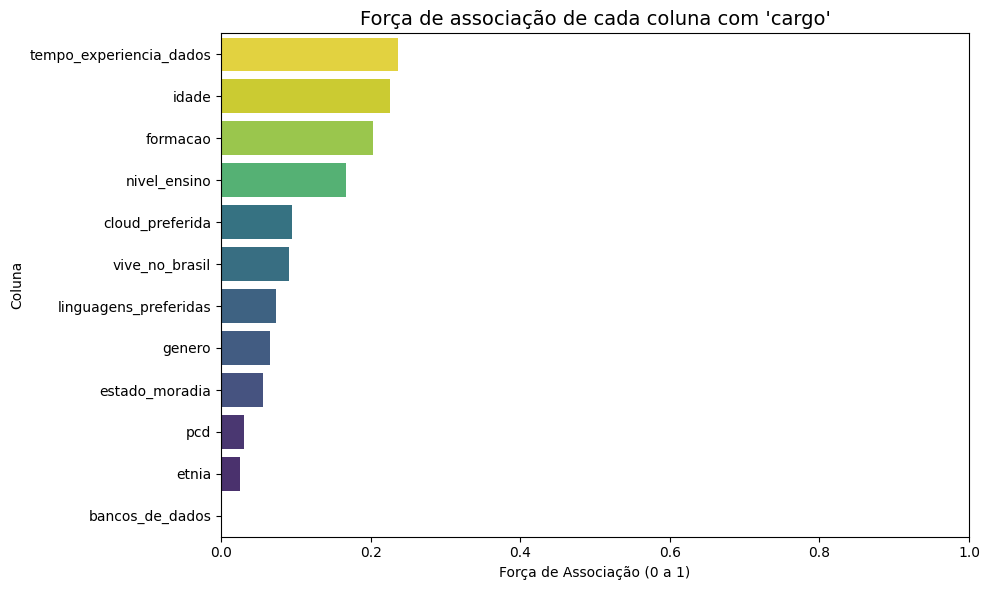

In [46]:
# ----- Funções auxiliares -----
def cramers_v_corrected(x, y):
    """Associação categórico↔categórico"""
    conf = pd.crosstab(x, y)
    if conf.size == 0:
        return np.nan
    chi2 = chi2_contingency(conf)[0]
    n = conf.to_numpy().sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = conf.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1)) if n > 1 else 0
    rcorr = r - ((r - 1)**2) / (n - 1) if n > 1 else r
    kcorr = k - ((k - 1)**2) / (n - 1) if n > 1 else k
    denom = min((kcorr - 1), (rcorr - 1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

def correlation_ratio(categories, measurements):
    """Associação numérico↔categórico"""
    mask = (~pd.isna(categories)) & (~pd.isna(measurements))
    if mask.sum() == 0:
        return np.nan
    categories = pd.Series(categories[mask], dtype="category")
    measurements = measurements[mask]
    overall_mean = measurements.mean()
    means = measurements.groupby(categories, observed=False).mean()
    counts = measurements.groupby(categories, observed=False).count()
    ss_between = (counts * (means - overall_mean)**2).sum()
    ss_total = ((measurements - overall_mean)**2).sum()
    return float(np.sqrt(ss_between / ss_total)) if ss_total != 0 else 0.0

# ----- Cálculo das associações com o target -----
associacoes = []

for col in dataset.columns:
    if col == target:
        continue
    if pd.api.types.is_numeric_dtype(dataset[col]):
        # numérico × categórico
        assoc = correlation_ratio(dataset[target], dataset[col])
    else:
        # categórico × categórico
        assoc = cramers_v_corrected(dataset[target], dataset[col])
    associacoes.append({"coluna": col, "associacao": assoc})

assoc_df = pd.DataFrame(associacoes).sort_values(by="associacao", ascending=False)

# ----- Plot -----
plt.figure(figsize=(10,6))
sns.barplot(data=assoc_df,
            x="associacao", 
            y="coluna", 
            hue="associacao",
            palette="viridis",
            legend=False,
            dodge=False)
plt.title(f"Força de associação de cada coluna com '{target}'", fontsize=14)
plt.xlabel("Força de Associação (0 a 1)")
plt.ylabel("Coluna")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


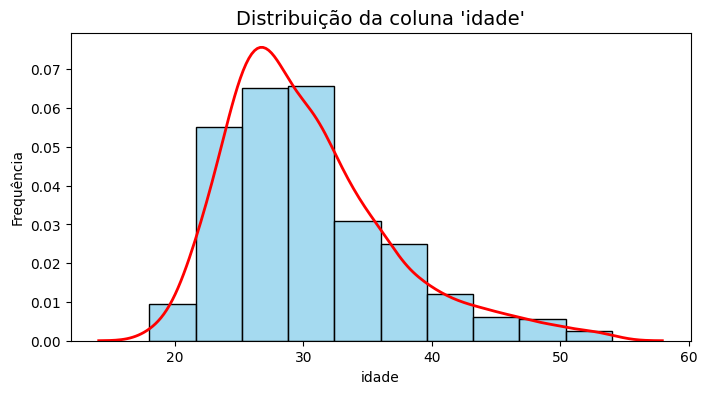

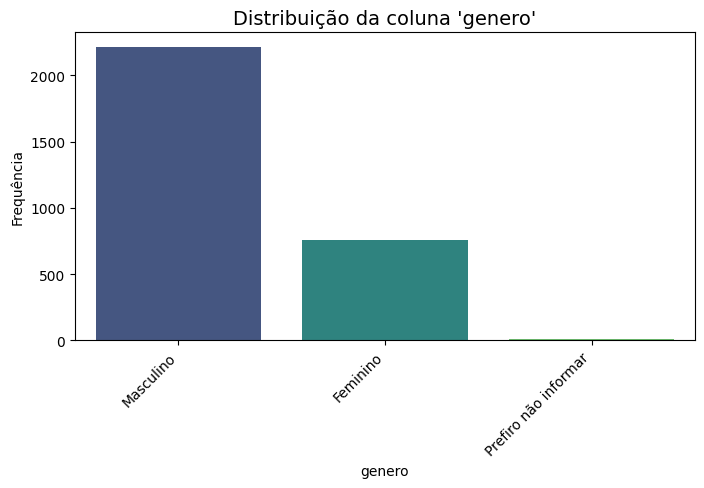

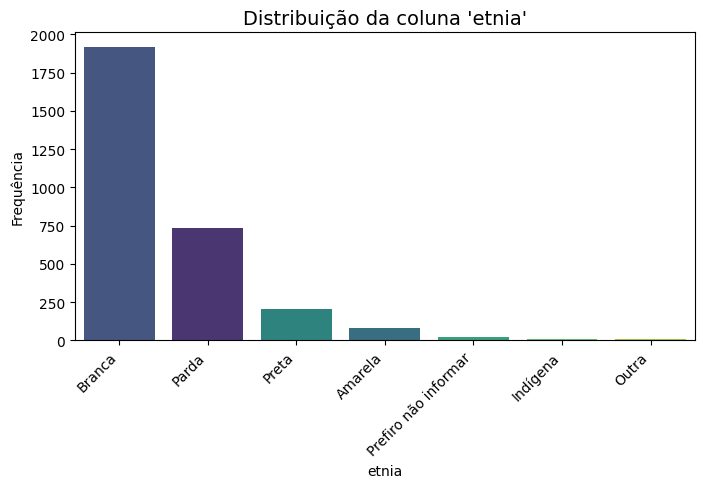

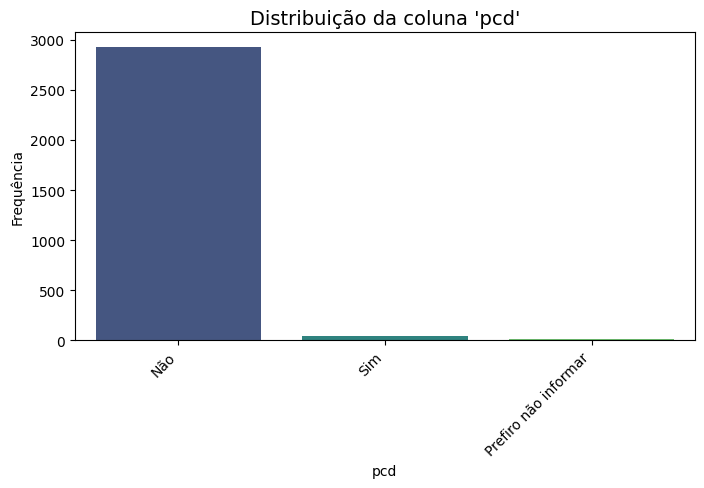

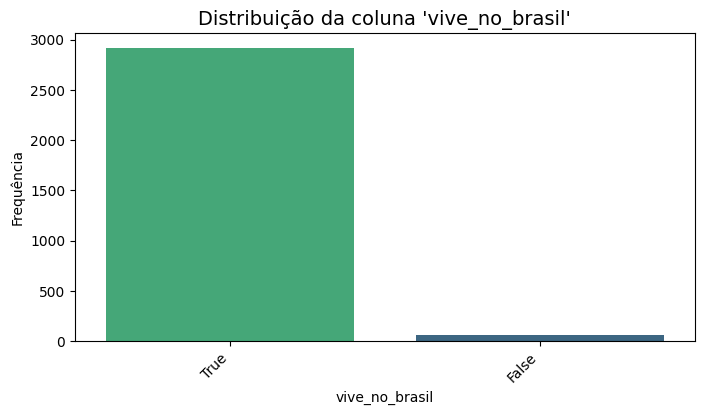

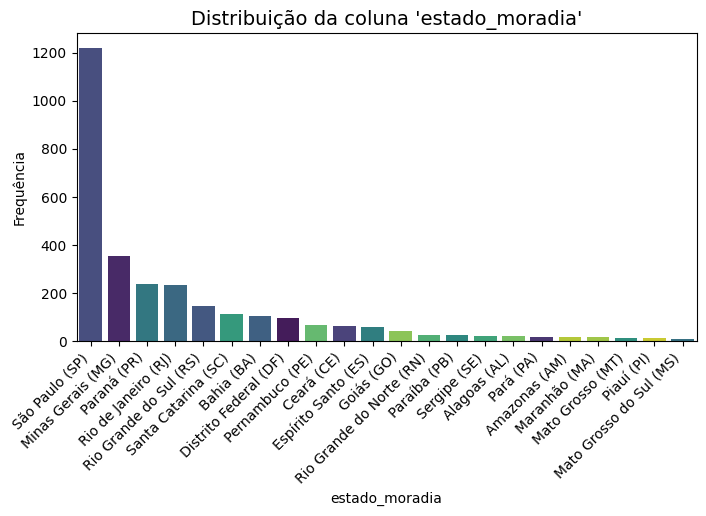

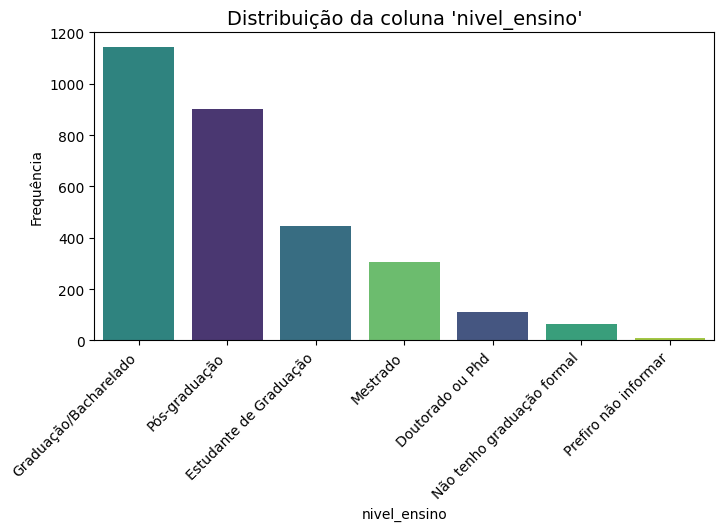

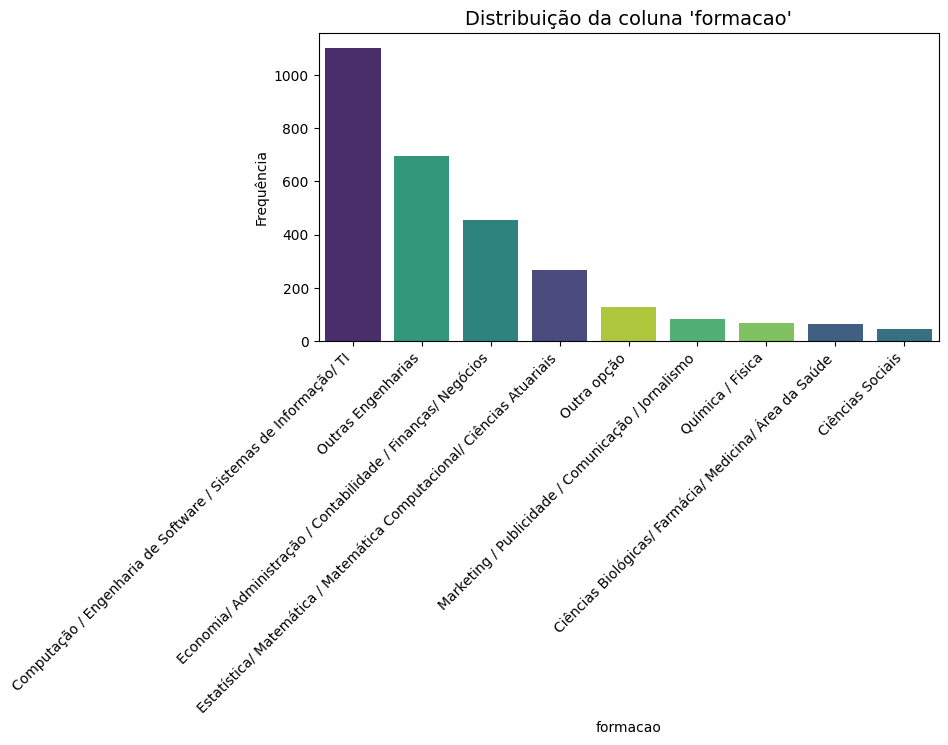

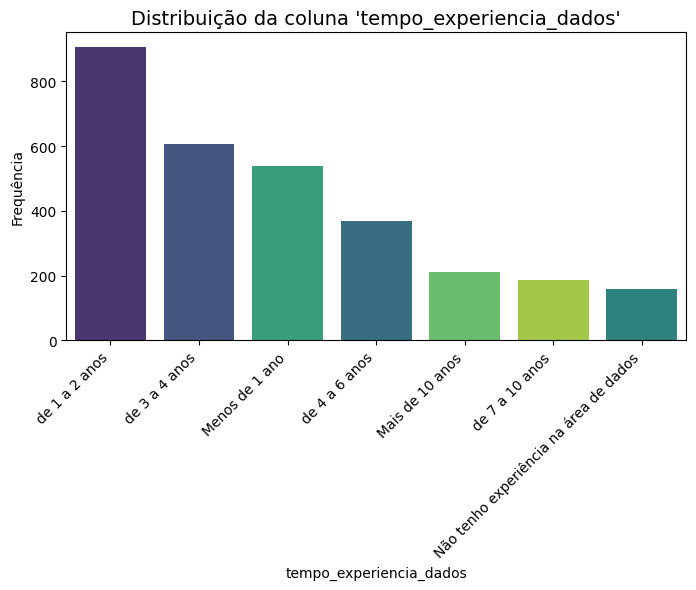

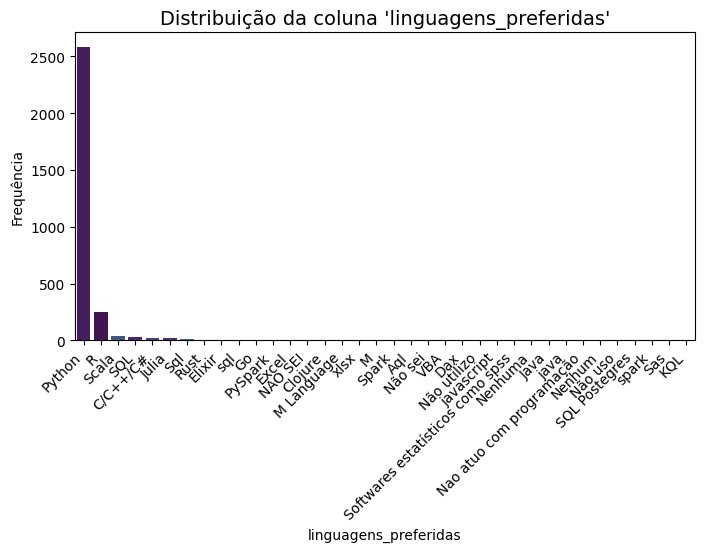

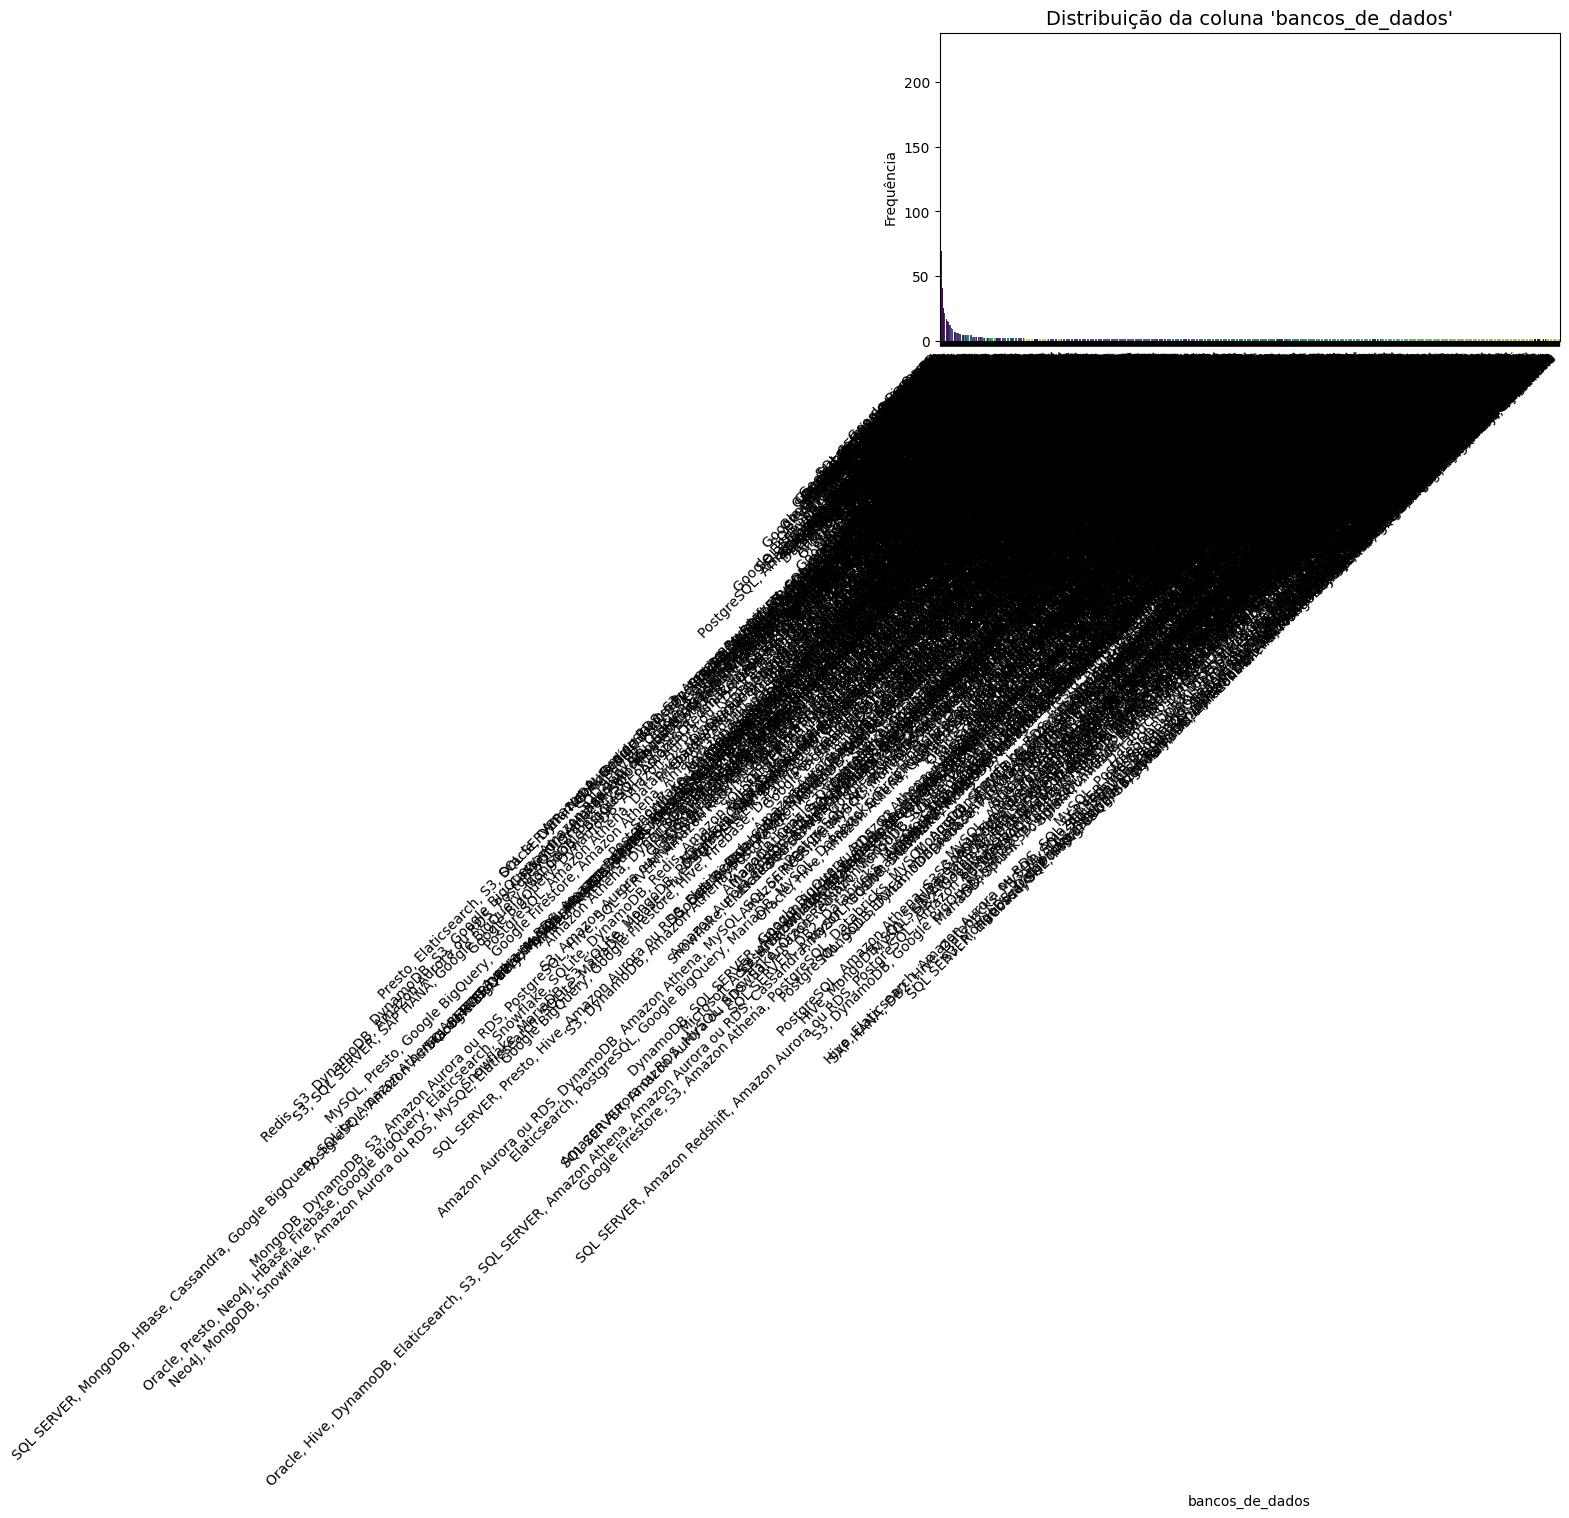

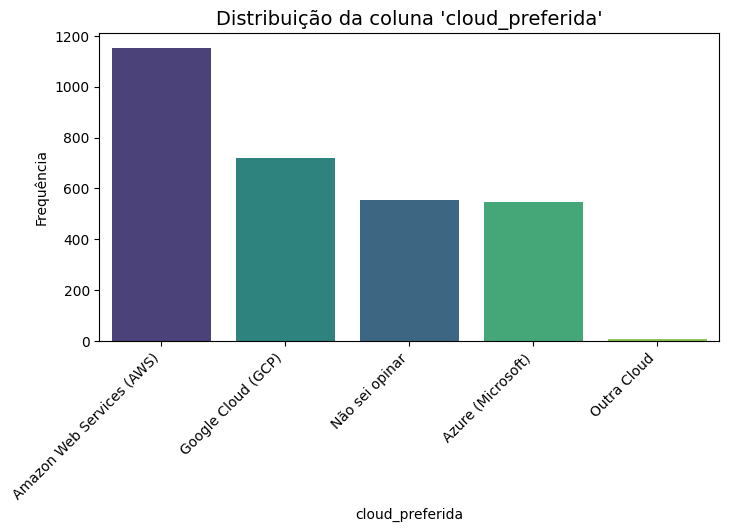

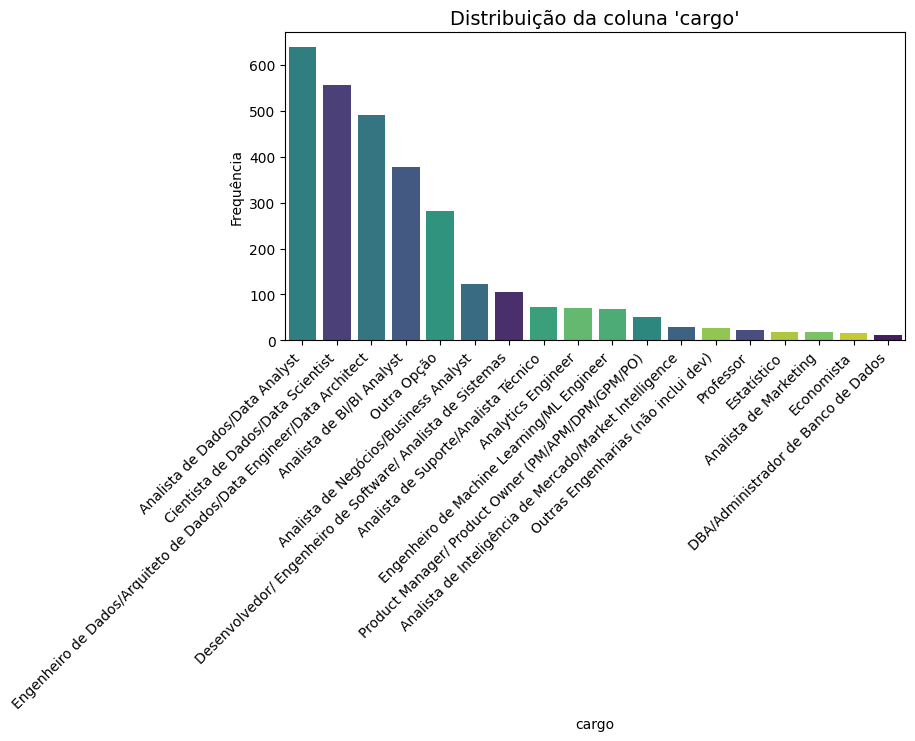

In [48]:
for col in dataset.columns:
    plt.figure(figsize=(8, 4))
    plt.title(f"Distribuição da coluna '{col}'", fontsize=14)

    if pd.api.types.is_numeric_dtype(dataset[col]) and col != "vive_no_brasil":
        # Coluna numérica: histograma + boxplot
        # sns.histplot(dataset[col], 
        #              kde=True, 
        #              color="skyblue", 
        #              bins=20, 
        #              line_kws={"linewidth": 2, "color": "red"})
        sns.histplot(dataset[col], 
             color="skyblue", 
             bins=10, 
             stat="density")

        sns.kdeplot(dataset[col], 
                    color="red", 
                    linewidth=2)
        plt.xlabel(col)
        plt.ylabel("Frequência")
        plt.show()

    else:
        # Coluna categórica: barras de frequência
        sns.countplot(data=dataset,
                      x=col,
                      order=dataset[col].value_counts().index, 
                      palette="viridis",
                      hue=col,
                      legend=False,
                      dodge=False)
        plt.xticks(rotation=45, ha="right")
        plt.xlabel(col)
        plt.ylabel("Frequência")
        plt.show()


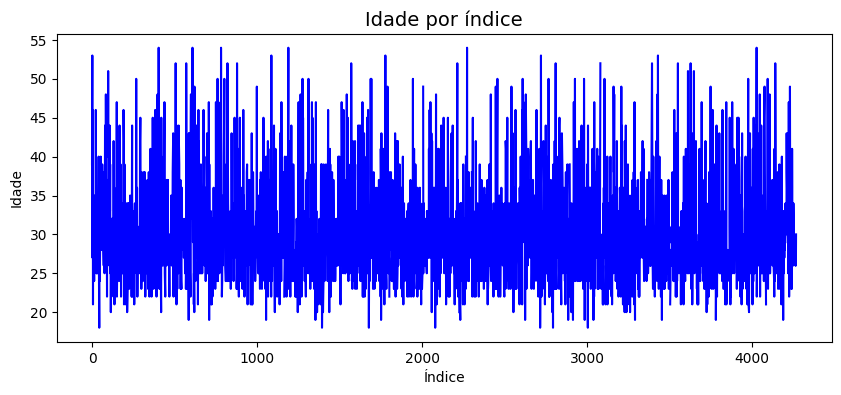

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(dataset.index, dataset["idade"], linestyle="-", color="blue")
plt.title("Idade por índice", fontsize=14)
plt.xlabel("Índice")
plt.ylabel("Idade")
plt.show()

### Conclusões obtidas
Cargo, é o nosso target, removi todas as linhas em que esse valor estava ausente, eram cerca de 30% e, diversas outras colunas tinham valores ausentes nos mesmos pontos, levando isso em consideração eliminamos as linhas, já que para preencher seriam muitos dados artificiais adicionados ao dataset. 

Com relação aos valores ausentes restantes no dataset, após a exclusão das linhas em que o target tinha valores ausentes, as outras linhas apresentaram um número bem reduzido, chegando à no máximo 1,73%, então vale a pena aplicar um método de preenchimento nessas linhas.

Idade, possui 38 valores ausentes, alta correlação com o target e, está desbalanceada, com grande parte dos dados concentrados entre 20 a 30 anos, porém não possui outliers. Inicialmente, não pretendo alterar nada, só tratar os valores ausentes.

Gênero, possui 6 valores ausentes, associação de média a baixa com o target e, está desbalanceada, a maior parte dos que responderam são do gênero masculino, menos da metade são do gênero feminino, e apenas uma quantia ínfima preferiu não responder. Será que vale a pena passar os prefiro não dizer para feminino? Ou, eliminar a coluna já que a correlação não é forte? 

Etnia, não possui valores ausentes, associação baixa com o target e, está desbalanceda, a maior parte dos que responderam são brancos, pardos são menos da metade dos brancos, pretas são menos da metade dos pardos e continua assim por amarela, prefiro não informar e indigena. Minha ideia inicial é eliminar a coluna, está desbalanceda e possui baixa correlação com o target, não considero válido manter a coluna.

PCD, não possui valores ausentes, associação baixa com o target e, está desbalanceada, não vi o número em si, mas pelo gráfico cerca de 97% dos que responderam não possuem deficiência. Minha ideia inicial é eliminar a coluna, está desbalanceda e possui baixa correlação com o target, não considero válido manter a coluna.

Vive no Brasil, não possui valores ausentes, associação média com o target e, está desbalanceada, não vi o número em si, mas pelo gráfico cerca de 97% vivem no Brasil. Vou manter a coluna e verificar se os modelos sofrem uma perda de desempenho ao remover essa coluna.

Estado de moradia, possui 72 valores ausentes, associação de média para baixa com o target e, está desbalanceada, com gramde parte dos participantes da pesquisa residindo em São Paulo. Minha ideia inicial é eliminar a coluna, está desbalanceda e possui baixa correlação com o target, não considero válido manter a coluna. 

Nível de ensino, não possui valores ausentes, associação alta com o target e, está desbalanceada, porém não tanto quanto as outras. Vou só utilizar sem alterar nada inicialmente.

Formação, possui 74 valores ausentes, associação alta com o target e, não está tão desbalanceada, porém as linhas tem mais de uma formação. Será que vale a pena isolar as formação? No caso se a linha tiver CC e SI, eu duplico a linha e uma terá CC e outra SI, mas não tenho noção dos colaterais que serão ocasionados, pode valer a tentativa.

Tempo de experiência, não possui valores ausentes, possui a maior associação com o target, não está tão desbalaceda. Vou só utilizar sem alterar nada inicialmente.

Lingragens preferidas, possui 2 valores ausentes, associação média com o target, está desbalanceada, não vi o número, mas pelo gráfico imagino que pelo menos 80% utilizam Python. Pode ser interessante retirar essa coluna, vou testar com e sem ela.

Banco de dados, possui 3 valores ausentes, associação ínfima com o target e, os dados possuem uma quantia enorme de classificações. Preciso isolar os tipos de bancos de dados utilizados, para ter uma noção melhor, do jeito que está atualmente não consigo definir a relevância dessa coluna para o target.

Cloud preferida, não possui valores ausentes, associação média com o target e, os dados estão até que balanceados, só a categoria outros que não possui muitos valores. Vou utilizar sem alterar nada inicialmente.

# Tratamento dos Dados

In [10]:
print("Teste")

Teste
